# Demo: Watershed on microglia 

### Get the watershed_3d package, version 0.0.2

In [1]:
!pip uninstall -y watershed_3d
!pip install https://github.com/acycliq/3d_watershed/raw/master/dist/watershed_3d-0.0.2-py3-none-any.whl

Found existing installation: watershed-3d 0.0.2
Uninstalling watershed-3d-0.0.2:
  Successfully uninstalled watershed-3d-0.0.2
  Using cached https://github.com/acycliq/3d_watershed/raw/master/dist/watershed_3d-0.0.2-py3-none-any.whl (11 kB)


### Import some other packages needed for this notebook

In [2]:
import watershed_3d as ws
import pandas as pd
import numpy as np
from scipy.sparse import coo_matrix
from PIL import Image, ImageDraw

DIPlib -- a quantitative image analysis library
Version 3.4.0 (Dec 13 2022)
For more information see https://diplib.org


In [3]:
print(ws.__version__)

0.0.2


### Do now the segmentation. Call the app method and pass in the path to the 3d-image and a list of the pages that havent been imaged properly

In [4]:
img_path = r"./microglia_ WT997_icvAB_Iba1_retiled.tif"
bad_pages = list(range(0, 16)) + [65, 66]

Internally the app() method does two things. First, it tries to adjust the brightness of the image and then segments it with watershed. There is a third arg in the app() method which is optional called 'do_rolling_ball' and by default is set to False. If there is an area of the image that is hugely overexposed compared to the rest and the adjustments carried out inside the app() method do not produce a good result, then maybe re-running app() with 'do_rolling_ball' = True would yield better results. However the algorithm will take a lot longer to finish, probably hours.

During the run, the app() method will save some images on the disk, look at the log messages about the exact location. It would be advisable to have a look at these images to get an idea about how well these adjustment work

The 'image_url' that is passed-in to app() should point to a 3d image that is in the format ZYX, ie numStacks-Height-Width 

In [5]:
masks = ws.app(image_url=img_path, exclude_pages=bad_pages)

2023-08-06 10:31:34,901 - watershed_3d - INFO - Adjusting the image
2023-08-06 10:32:40,535 - watershed_3d - INFO - black and white image saved at ./debug/bw_image.tiff
2023-08-06 10:32:45,203 - watershed_3d - INFO - curve-adjusted image saved at ./debug/adj_img.tiff
2023-08-06 10:32:45,236 - watershed_3d - INFO - Started watershed
2023-08-06 10:39:32,566 - watershed_3d - INFO - Finished watershed
2023-08-06 10:39:32,566 - watershed_3d - INFO - stitching the 2d masks
2023-08-06 10:40:49,309 - watershed_3d - INFO - stitching finished
2023-08-06 10:40:52,347 - watershed_3d - INFO - stitched_masks saved at ./debug/stitched_masks.npy
2023-08-06 10:41:05,470 - watershed_3d - INFO - Saved some segmented images at ./debug/segmentation_samples


You can have a preview of the performance of watershed by looking at the images saved in ./debug/segmentation_samples

In [6]:
# lets see what the max label is
masks.max()

203974

In [7]:
# lets see now how many distinct labels we have (this will take some seconds...)
np.unique(masks).shape

(203975,)

So, the number of distinct labels is greater than the max number by one? 
Yes, because the number 203975 includes 0, the background.
Hence these two numbers make sense and the microglia shapes have been labelled in 
sequential manner, there are no gaps in the labels

Lets now try to assign the spots to these microglia shapes

## Spot assignement

In [8]:
spots = pd.read_csv('spots_WT997_icvAB_OMP_restitched.csv')
spots

,y,x,z_stack,Gene
0,5680.0,2117.0,15.0,1500015O10Rik/Ecrg4
1,5756.0,3475.0,48.0,1500015O10Rik/Ecrg4
2,5783.0,2788.0,40.0,1500015O10Rik/Ecrg4
3,5787.0,2574.0,45.0,1500015O10Rik/Ecrg4
4,5964.0,2628.0,23.0,1500015O10Rik/Ecrg4
...,...,...,...,...
683513,2004.0,290.0,47.0,Vtn
683514,2010.0,292.0,44.0,Vtn
683515,1132.0,1759.0,59.0,Xaf1
683516,1134.0,1758.0,57.0,Xaf1


To assign the spots, call the label_spots() method and pass in the spots dataframe and the masks array that you produced a few steps above from watershed.

The spots dataframe needs to have at least three columns with names 'x', 'y' and 'z_stack'. The label_spots() method will then append and extra column with the name 'label' at the end of this dataframe. It shows which shape the spots has been assigned to. If label=0 then the spot is on the background

In [9]:
spots_labeled = ws.label_spots(spots, masks)
spots_labeled

2023-08-06 10:42:19,464 - watershed_3d - INFO - doing 6
2023-08-06 10:42:19,473 - watershed_3d - INFO - doing 9
2023-08-06 10:42:19,474 - watershed_3d - INFO - doing 15
2023-08-06 10:42:19,474 - watershed_3d - INFO - doing 11
2023-08-06 10:42:19,476 - watershed_3d - INFO - doing 13
2023-08-06 10:42:19,602 - watershed_3d - INFO - doing 8
2023-08-06 10:42:19,622 - watershed_3d - INFO - doing 10
2023-08-06 10:42:19,624 - watershed_3d - INFO - doing 12
2023-08-06 10:42:19,631 - watershed_3d - INFO - doing 14
2023-08-06 10:42:19,663 - watershed_3d - INFO - doing 19
2023-08-06 10:42:19,665 - watershed_3d - INFO - doing 17
2023-08-06 10:42:19,672 - watershed_3d - INFO - doing 21
2023-08-06 10:42:19,832 - watershed_3d - INFO - doing 16
2023-08-06 10:42:20,017 - watershed_3d - INFO - doing 23
2023-08-06 10:42:20,027 - watershed_3d - INFO - doing 25
2023-08-06 10:42:20,068 - watershed_3d - INFO - doing 18
2023-08-06 10:42:20,075 - watershed_3d - INFO - doing 27
2023-08-06 10:42:20,082 - watershe

,y,x,z_stack,Gene,label
157032,5635.0,1358.0,6.0,Gpr17,0
18445,7077.0,3483.0,8.0,Cd81,0
19154,7305.0,2873.0,8.0,Cd81,0
65039,6767.0,3163.0,8.0,Pld3,0
67509,7266.0,3044.0,8.0,Pld3,0
...,...,...,...,...,...
683154,895.0,1498.0,65.0,Vtn,0
683157,900.0,1511.0,65.0,Vtn,0
683228,1112.0,1363.0,65.0,Vtn,0
683312,1433.0,525.0,65.0,Vtn,0


## Sanity checking

Lets now play around with one mask and do some sanity checking. This section will also help us to get a better grasp of the data and what they mean.

Pick up the mask that corresponds to the 20th image in the 3d stack

In [10]:
mask_20 = masks[20]

mask_20 is an array with a lot of zeros (that correspond to the background) and some integer values (labels) that correspond to the microglia shapes.

The lines in the cell below: <br>
    &emsp; 1. convert the array to a boolean, true if the pixel is in microglia, false otherwise <br>
    &emsp;2. convert the boolean to binary (255 if microglia, 0 otherwise)<br>
    &emsp;3. Changes the type to unit8 (necessary to to the image)<br>
    &emsp;4. Does the image from the array

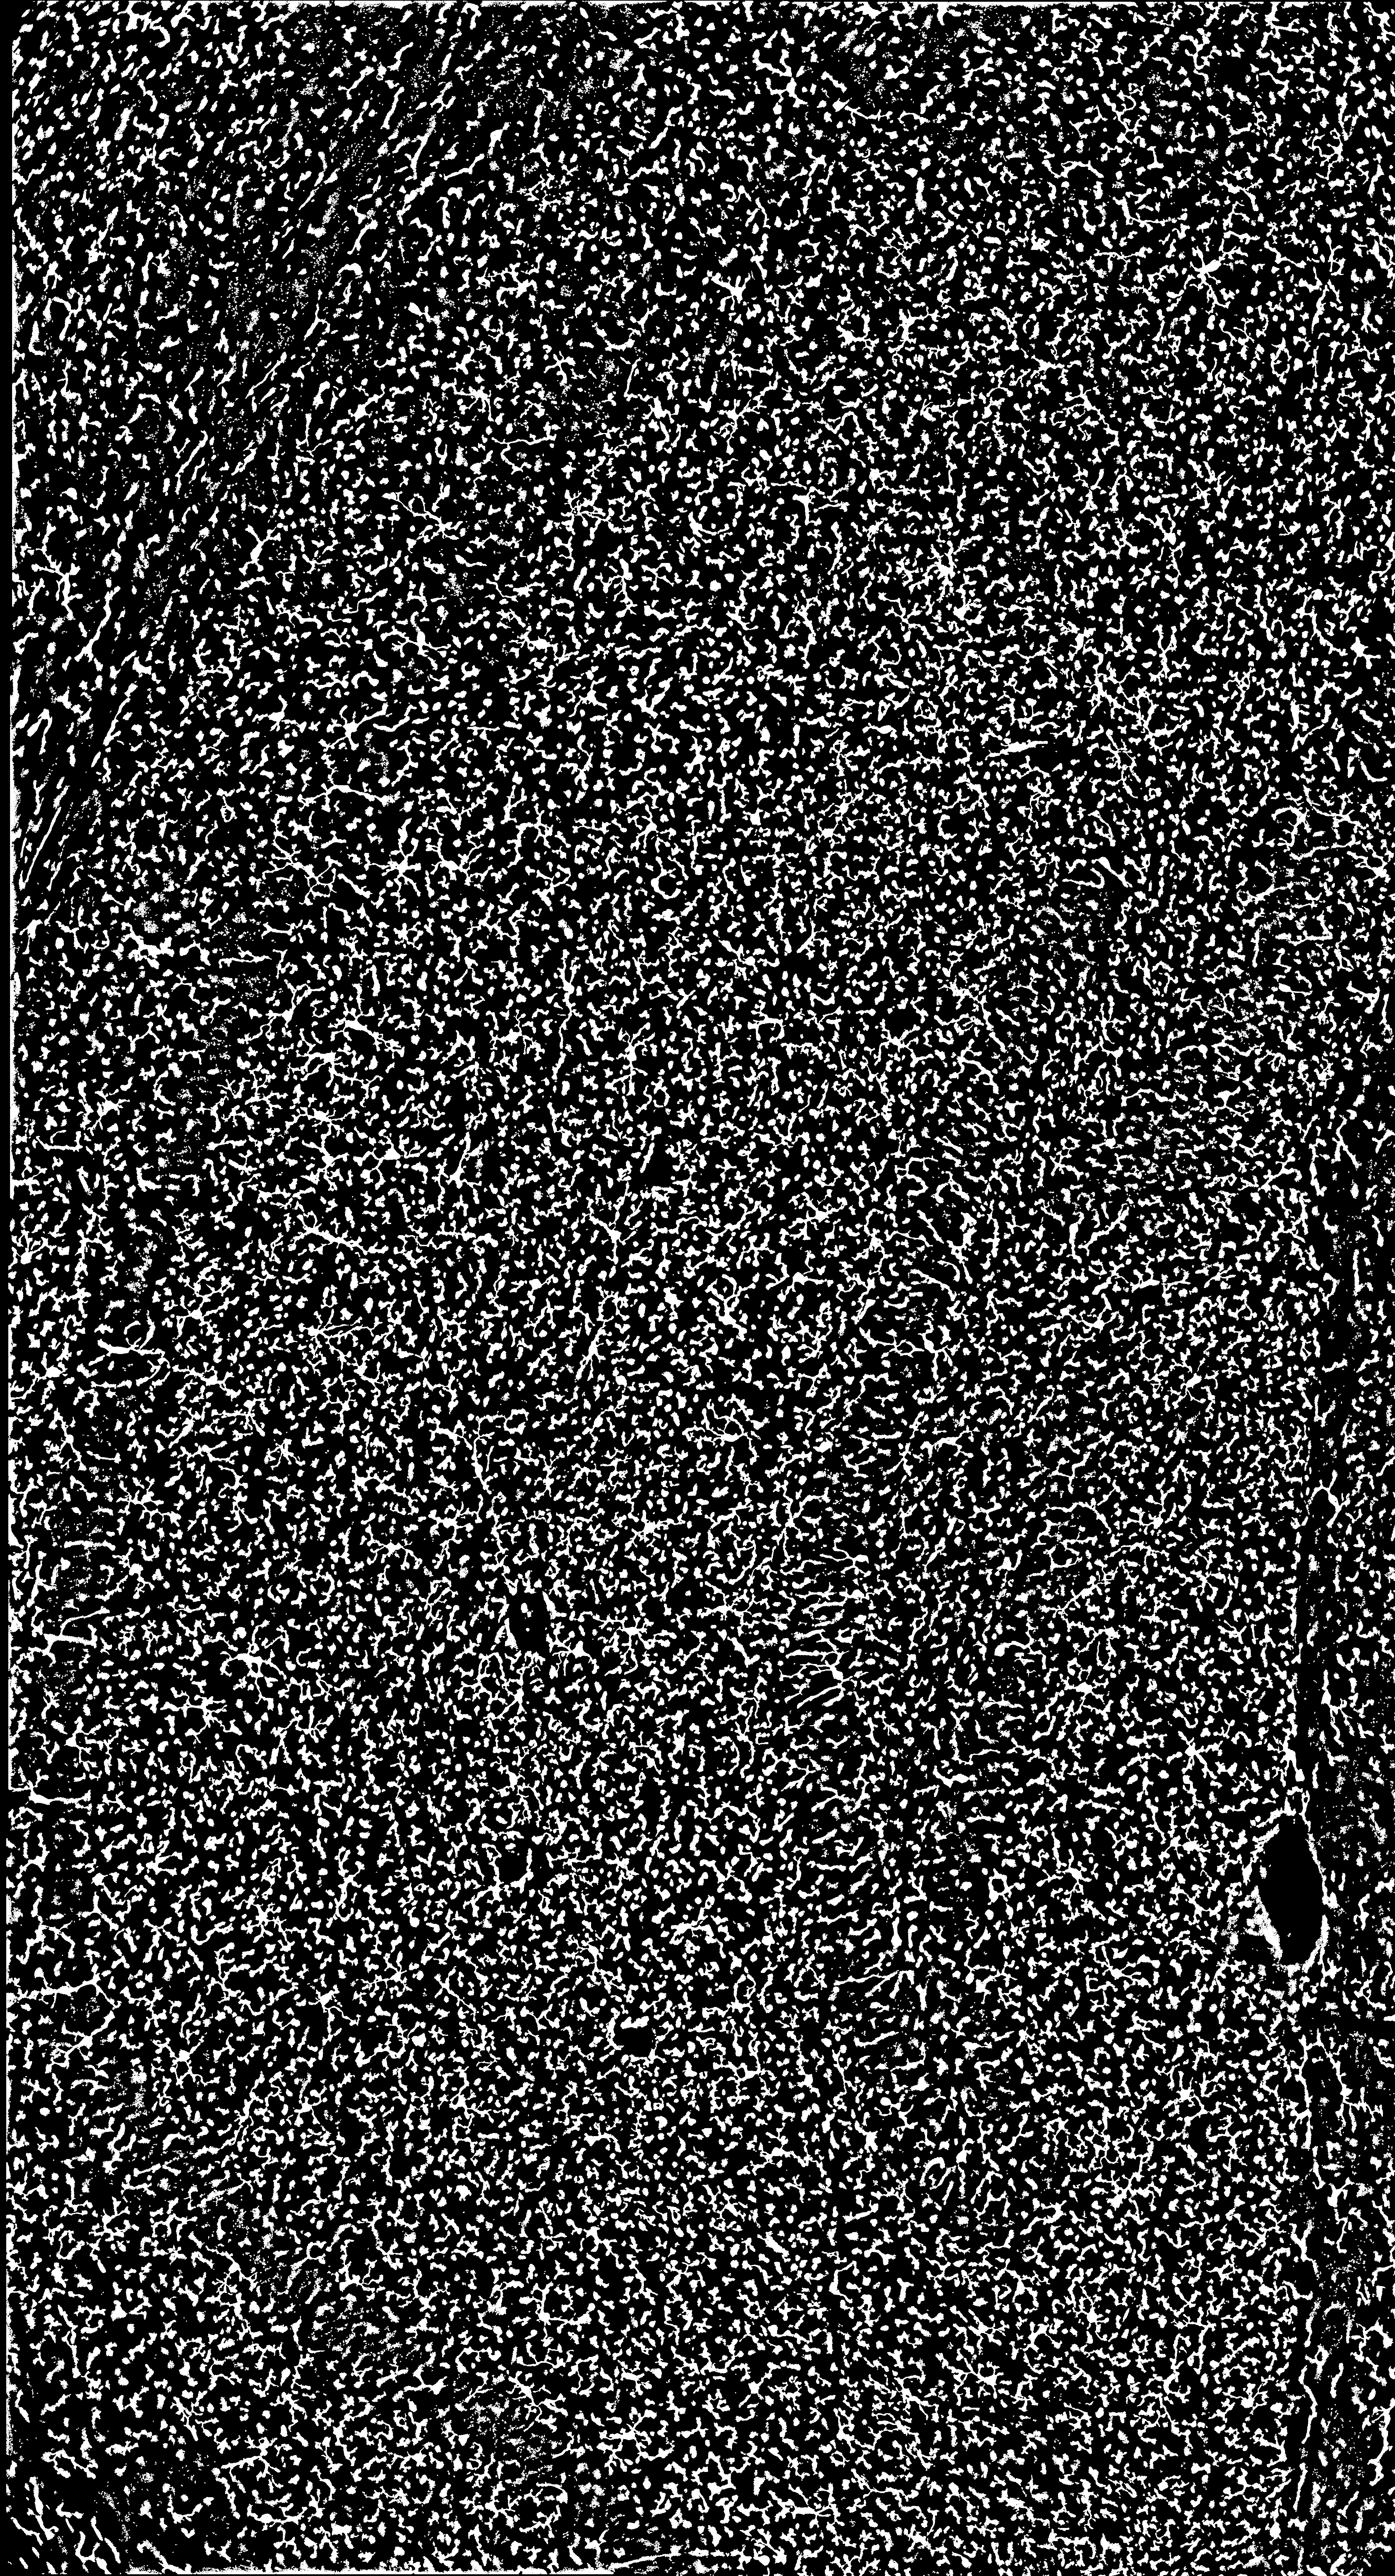

In [11]:
m = mask_20 > 0
m = 255 * m
m = m.astype(np.uint8)
Image.fromarray(m)

The image above is a black and white image of the segmented 20th page (frame) of the 3d-image

Les now see which shapes are the biggest

In [12]:
uid, cts = np.unique(mask_20, return_counts=True) 

In [13]:
df = pd.DataFrame({'label':uid, 'area': cts}).sort_values(by=['area'], ascending=False)
df

,label,area
0,0,23036039
4333,6779,24348
13598,22603,20435
12107,18691,19106
11631,17540,16970
...,...,...
5122,7932,9
7741,11403,9
13123,21287,9
5682,8648,9


The dataframe above shows the area, in pixels, that each shape covers. As expected the background (label=0) covers a big part of the image.

But how about the shape with label=6779. Can we see which one it is?

Yes we can do this by the following code:

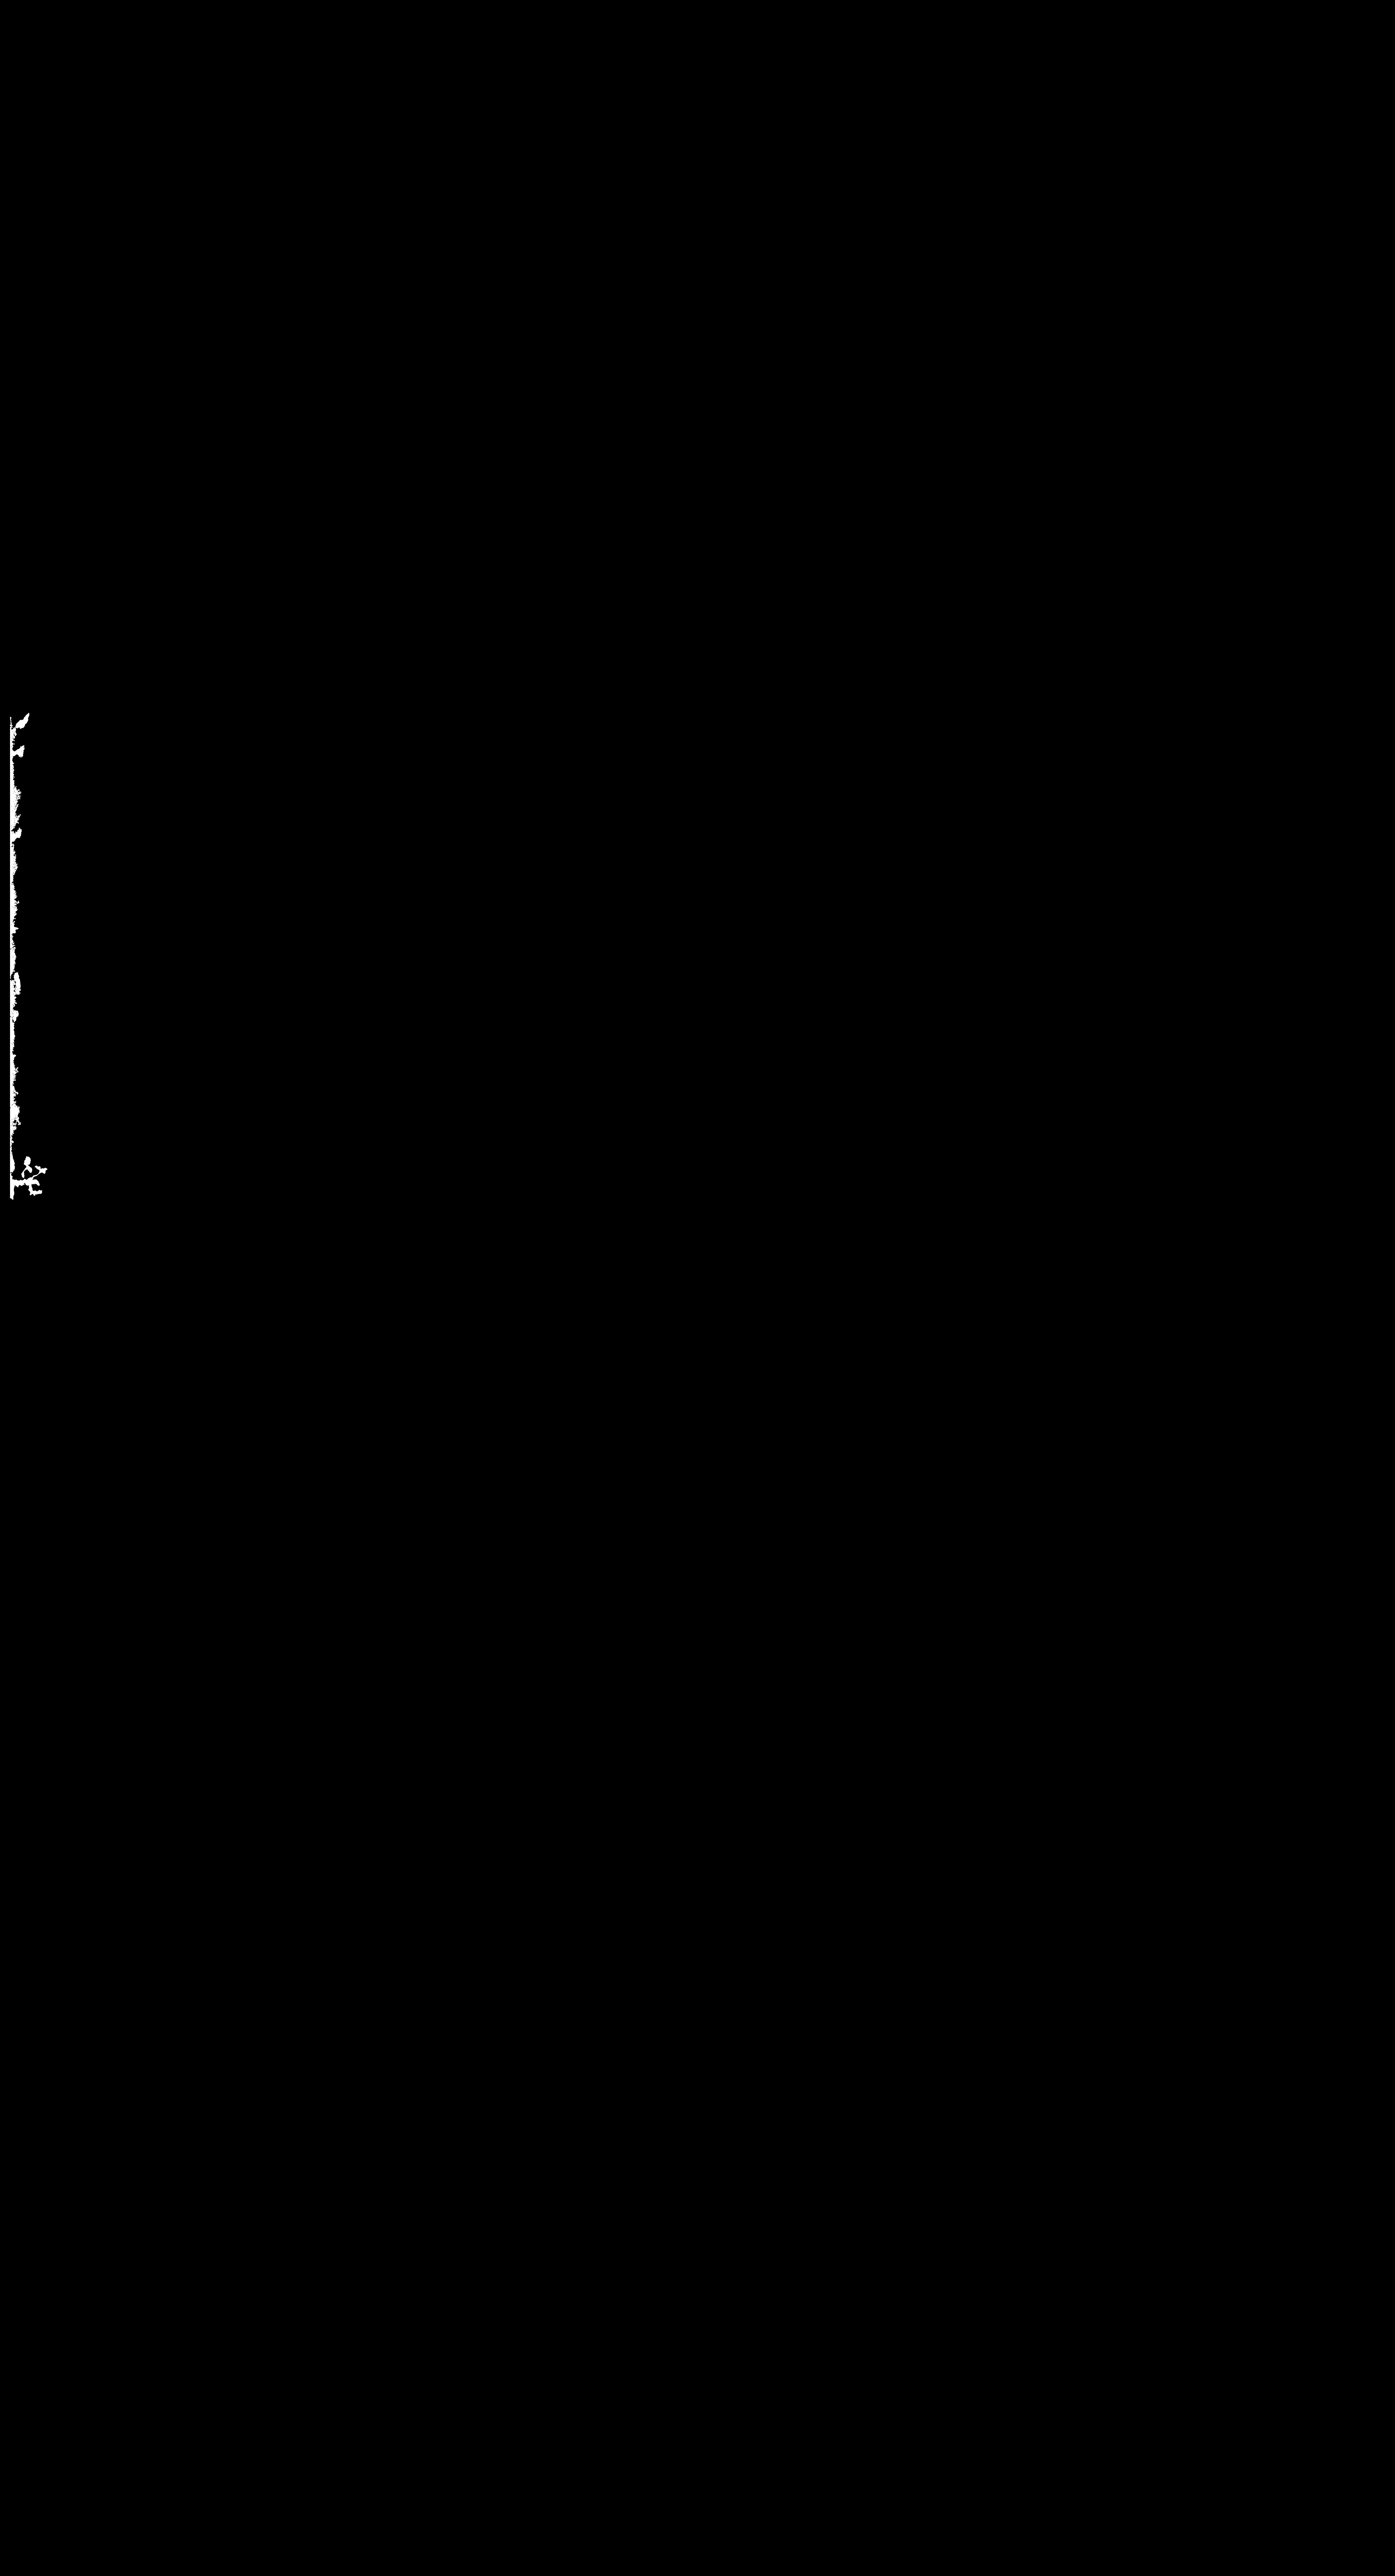

In [14]:
t = mask_20 == 6779 # True if label=6779, False otherwise
t = t.astype(np.uint8)
t = t * 255
Image.fromarray(t.astype(np.uint8))

Ah, dissapointing! It is one of the funny ones at the edges of the image. In fact quite a few of the shapes in the top of the dataframe above are like that; Shapes at the edges

Ok, lets look deeper into that dataframe, lower than the top5

In [15]:
df.head(20)

,label,area
0,0,23036039
4333,6779,24348
13598,22603,20435
12107,18691,19106
11631,17540,16970
12047,18568,15445
3960,6172,14514
10827,15619,12397
10234,14132,11135
8561,12223,10972


Lets pick up label 21471

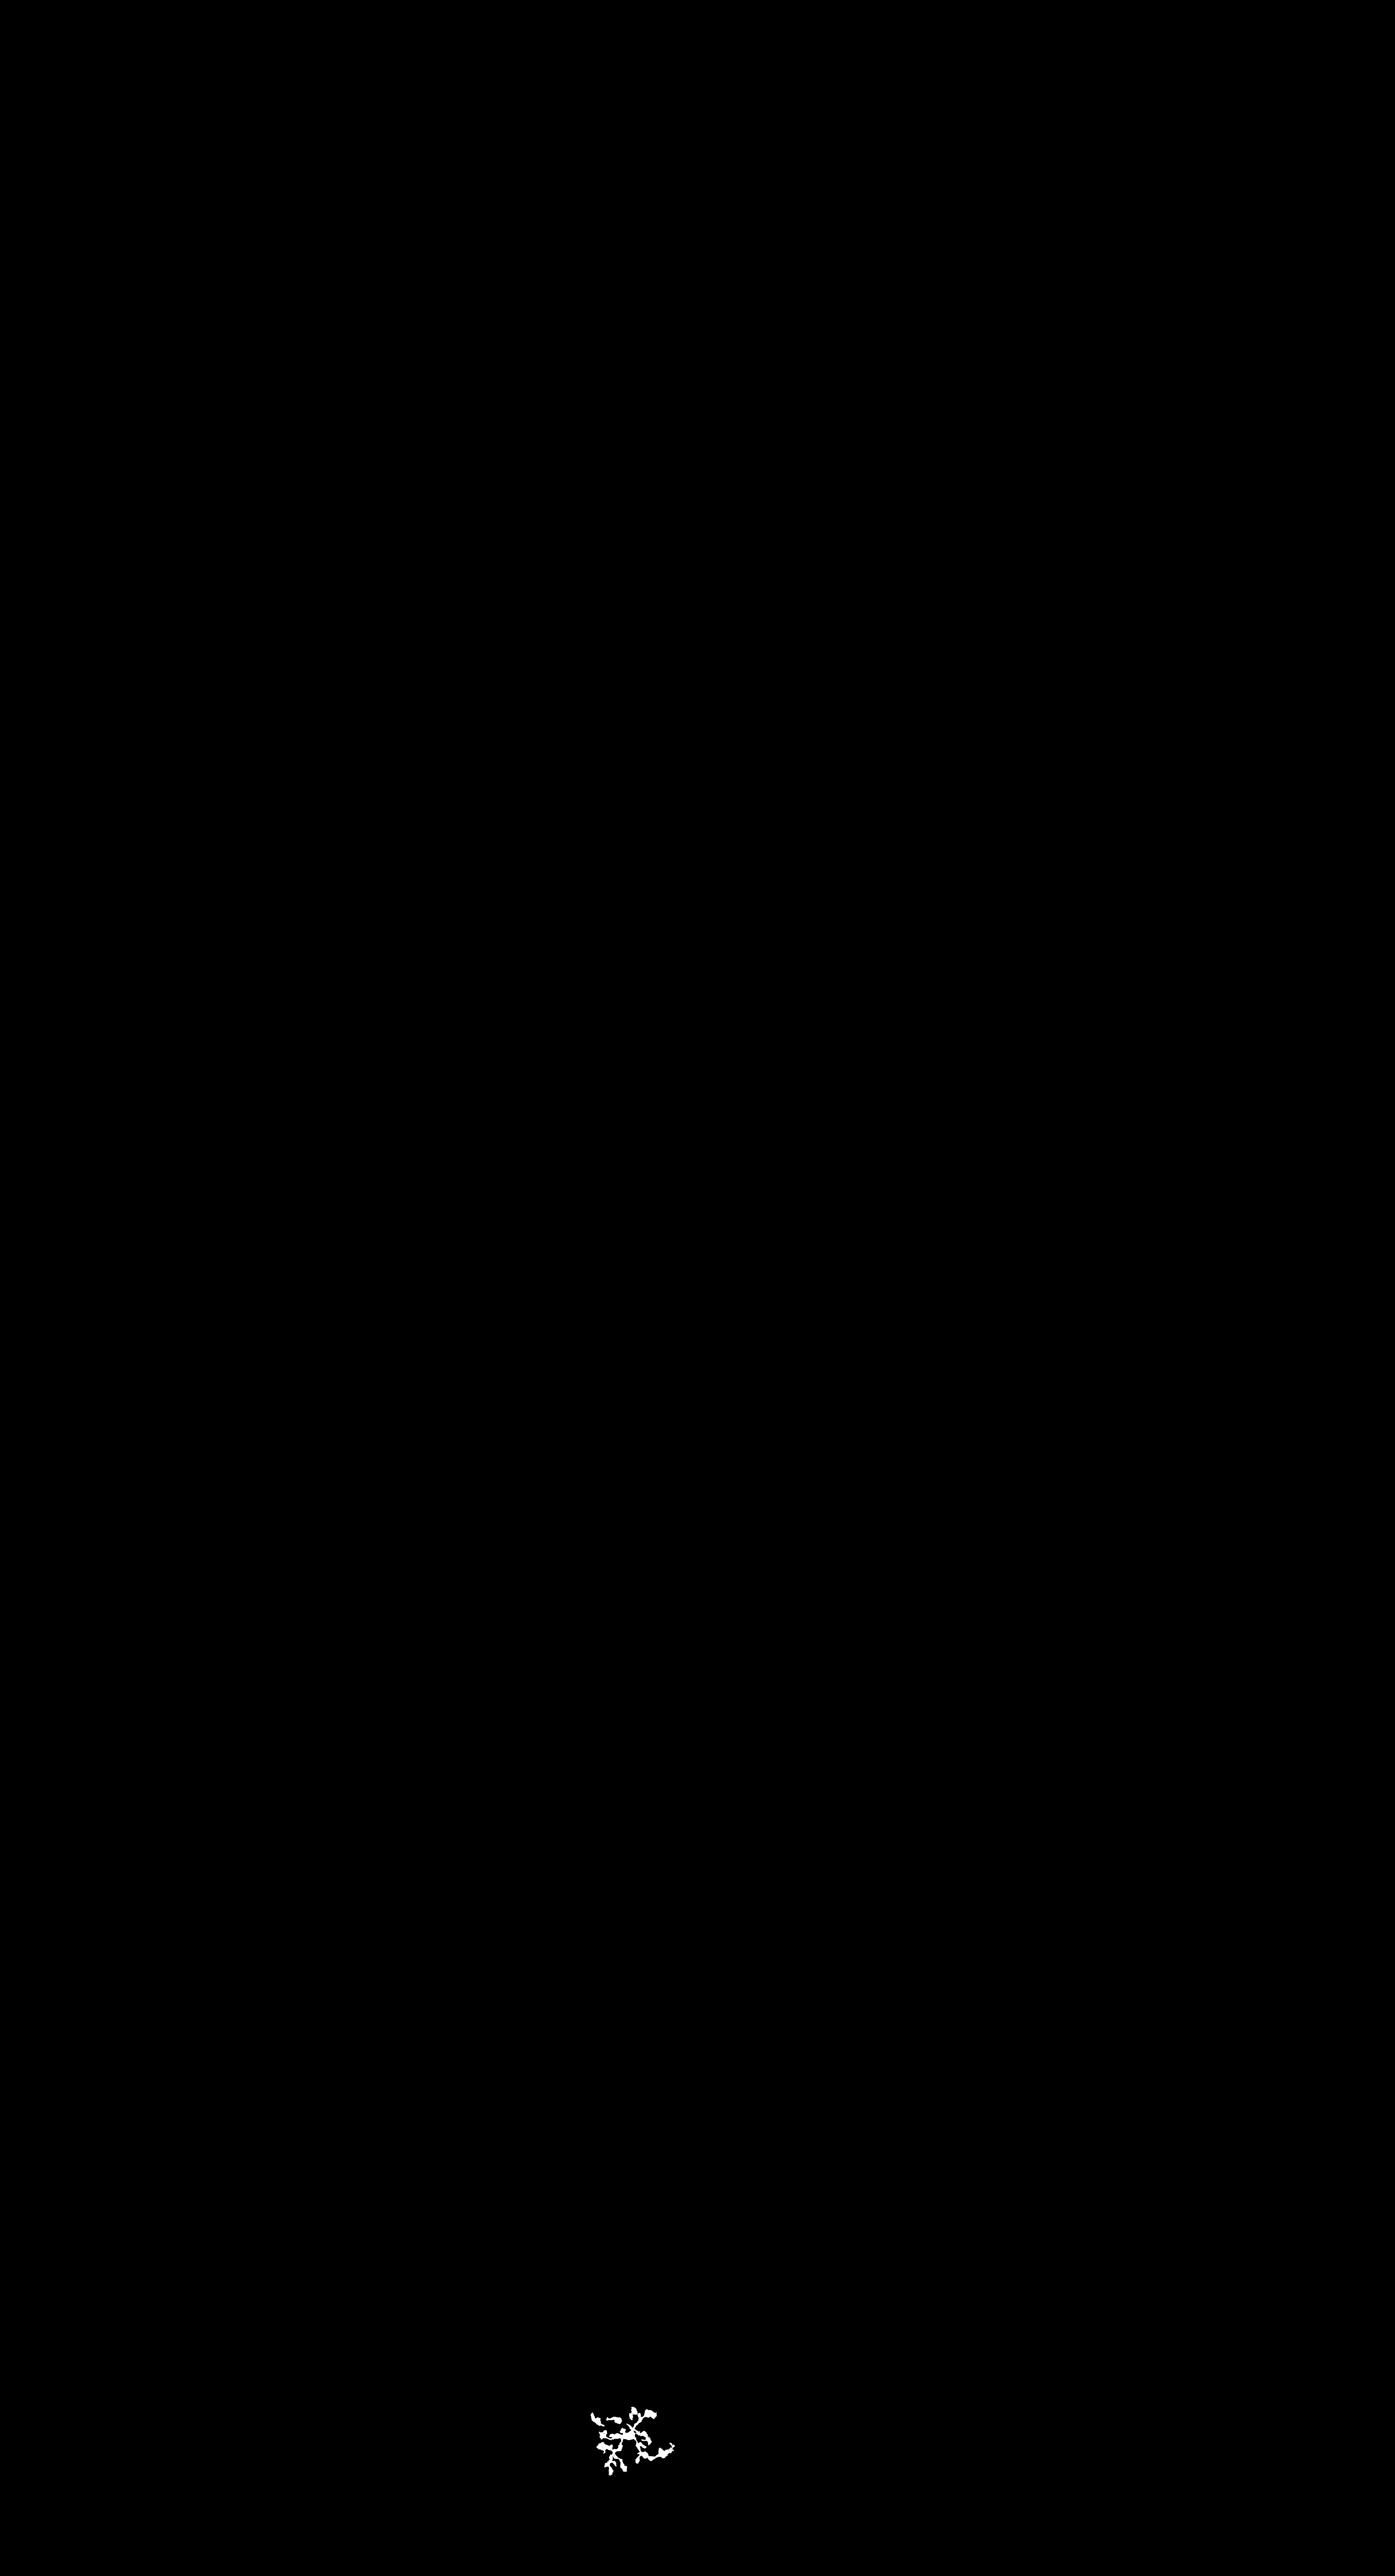

In [16]:
t = mask_20 == 21471
t = t.astype(np.uint8)
t = t * 255
microglia_21471 = Image.fromarray(t.astype(np.uint8))
microglia_21471

That looks to be a nice typical miroglia shape!

But how about the spots. Has the label_spots() method (a few steps earlier) done a good job and assigned them properly? 

Lets select the spots that have been assigned to microglia with label 21471 then

In [17]:
idx = spots_labeled.label == 21471
spots_21471 = spots_labeled[idx]
spots_21471

,y,x,z_stack,Gene,label
106893,7120.0,1768.0,16.0,Arpc2,21471
124925,7092.0,1794.0,16.0,Cd81,21471
156456,7040.0,1766.0,16.0,Gng12,21471
184644,7060.0,1819.0,16.0,Pld3,21471
200323,7041.0,1756.0,16.0,Qk,21471
...,...,...,...,...,...
191335,7079.0,1727.0,49.0,Ptk2b,21471
108546,7039.0,1763.0,50.0,Atp6v0c,21471
132911,7037.0,1771.0,51.0,Cotl1,21471
118513,7038.0,1753.0,53.0,Car2,21471


180 points in total. We will now overlay those spots on the microglia

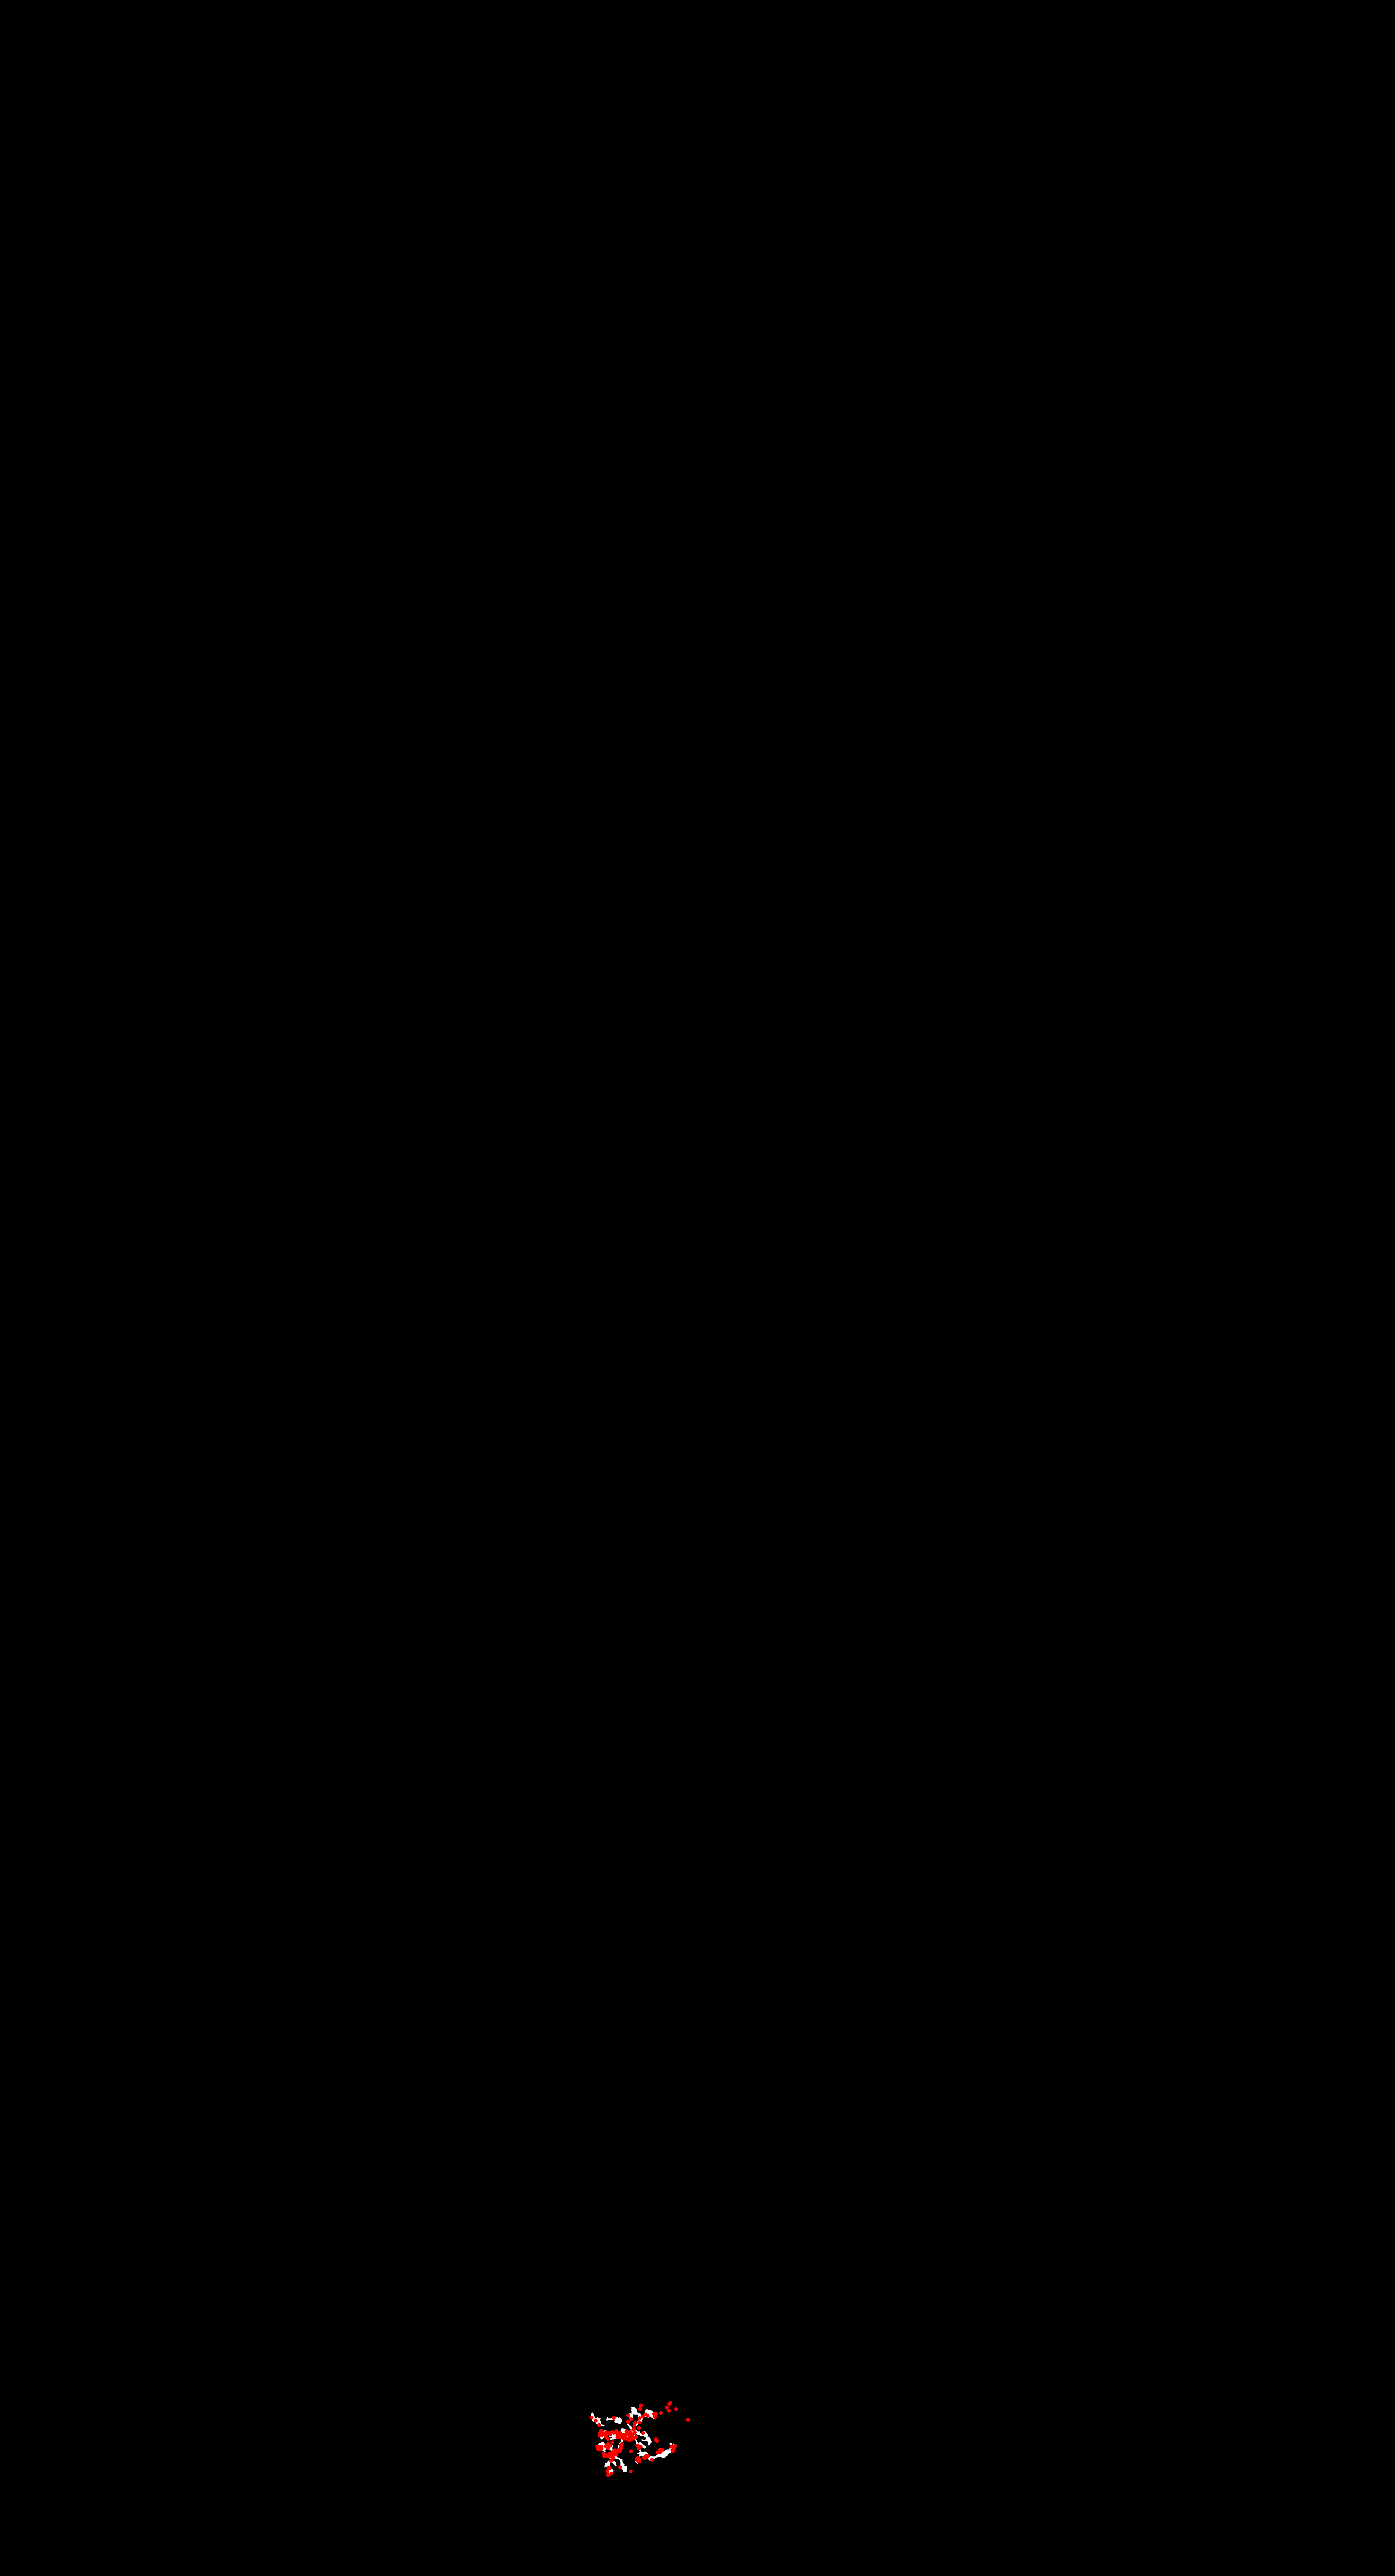

In [18]:
# Create a new transparent image of the same size as the original image
overlay = Image.new("RGBA", microglia_21471.size, (255, 255, 255, 0))
draw = ImageDraw.Draw(overlay)#

# Define a color for the random points (red in this case)
point_color = (255, 0, 0, 255)

# draw now the cirles and paint them red
for index, row in spots_21471.iterrows():
    point_size = 5
    x0, y0 = row['x'] - point_size, row['y'] - point_size
    x1, y1 = row['x'] + point_size, row['y'] + point_size
    draw.ellipse([x0, y0, x1, y1], fill=point_color)

# overlay now the dots onto the microglia
combined_img = Image.alpha_composite(microglia_21471.convert("RGBA"), overlay)
combined_img

Hmm, that looks a bit puzzling. The spots look to be clustered on the correct area but not exactly. Clearly there are spots that are outside the boundaries, why is that??

Because the dataframe above (the one with name 'spots_21471') has all the spots across the full z-stack. We are looking at mask 20 here but we have plotted the spots for all Zs

Ah ok, so lets focus on the spots for z=20 then!

In [19]:
# Christina, i need to explain the logic behind the line below!
idx = np.floor(spots_21471.z_stack == 20) > 0

In [20]:
# this dataframe has the spots assigned to microglia 21471 and 
# they are on the 20th location in the z-stack
spots_21471_z20 = spots_21471[idx]
spots_21471_z20

,y,x,z_stack,Gene,label
112567,7095.0,1773.0,20.0,C1qb,21471
113127,7043.0,1811.0,20.0,C1qc,21471
127303,7048.0,1829.0,20.0,Cd9,21471
130976,7110.0,1870.0,20.0,Cldn5,21471
138820,7039.0,1823.0,20.0,Ctsd,21471
140661,7047.0,1805.0,20.0,Ctss,21471
140728,7117.0,1886.0,20.0,Ctss,21471
162666,7056.0,1809.0,20.0,Hexb,21471
162668,7057.0,1828.0,20.0,Hexb,21471
162700,7094.0,1777.0,20.0,Hexb,21471


Lets try to overlay these points now to microglia_21471. It looks to be only 14 spots

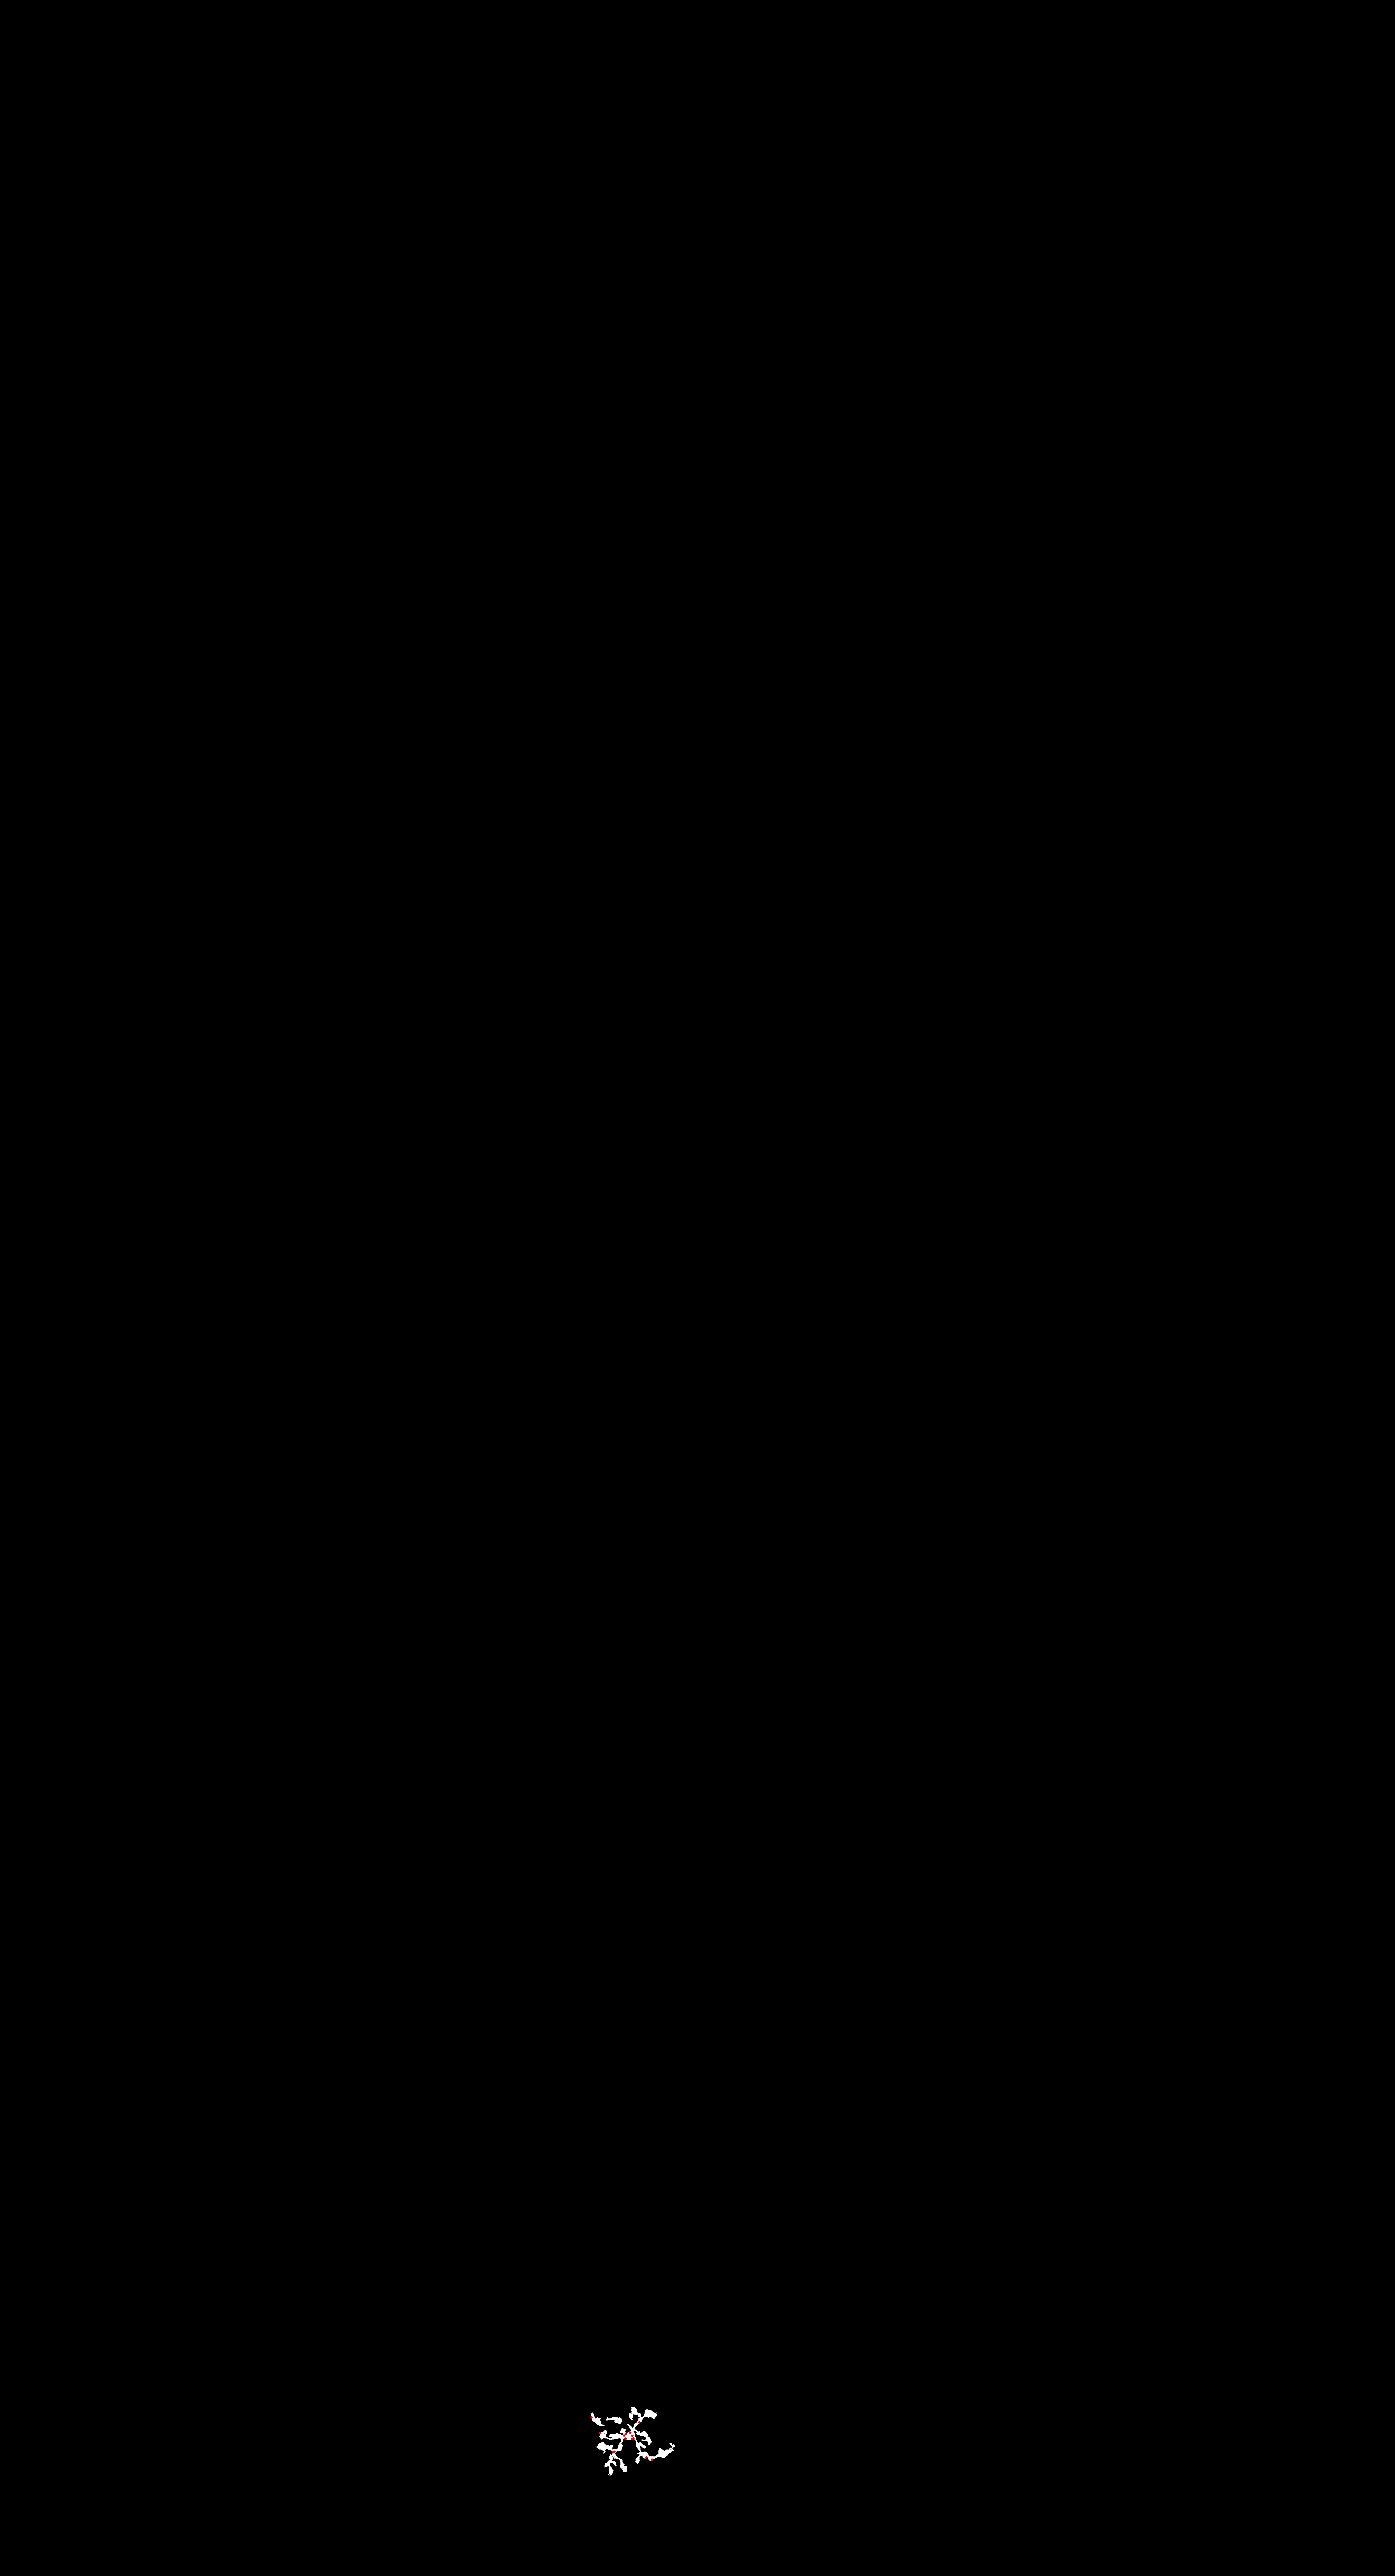

In [21]:
# Create a new transparent image of the same size as the original image
overlay = Image.new("RGBA", microglia_21471.size, (255, 255, 255, 0))
draw = ImageDraw.Draw(overlay)#

# Define a color for the random points (red in this case)
point_color = (255, 0, 0, 255)

# draw now the cirles and paint them red
for index, row in spots_21471_z20.iterrows():
    point_size = 3
    x0, y0 = row['x'] - point_size, row['y'] - point_size
    x1, y1 = row['x'] + point_size, row['y'] + point_size
    draw.ellipse([x0, y0, x1, y1], fill=point_color)

# overlay now the dots onto the microglia
combined_img = Image.alpha_composite(microglia_21471.convert("RGBA"), overlay)
combined_img

That looks better! Can we have a closer look.

Ok, lets crop the image then. We need to get some idea of the area to crop

In [22]:
padding = 10

In [23]:
xmin = spots_21471.x.min() - padding
ymin = spots_21471.y.min() - padding
xmax = spots_21471.x.max() + padding
ymax = spots_21471.y.max() + padding

Lets crop the image.

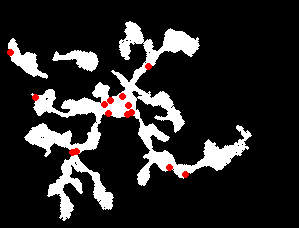

In [24]:
crop = combined_img.crop((xmin, ymin, xmax, ymax))
crop

It doesnt look that bad, Actually, it makes sense. All spots are within the shape. It seems that the label_spots() function works as expected